## Setup



In [1]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute, transpile, Aer, IBMQ # circuit creation and execution
from qiskit.providers.aer.noise import NoiseModel # simulate backends
from qiskit.visualization import plot_histogram # visualize results
from qiskit.quantum_info import Statevector, state_fidelity, hellinger_fidelity # statevector and metrics
from qiskit.providers.ibmq import least_busy # get least busy device
import qiskit.tools.jupyter # visualize backends
from qiskit.circuit.library.standard_gates.rx import RXGate
# from qiskit.ignis.mitigation.measurement import complete_meas_cal,CompleteMeasFitter # measurement error mitigation

import pandas as pd # handy tools for calculation
from numpy import pi
import pandas as pd
import matplotlib.pyplot as plt

# global vars
n = 3 # number of qubits
shots = 1000 # high number of shots per execution

## Own Code

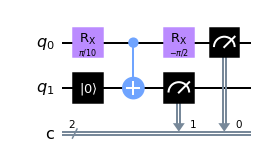

In [2]:
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.rx(pi/10, qreg_q[0])
circuit.reset(qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.rx(-pi/2, qreg_q[0])
circuit.measure(qreg_q[1], creg_c[1])
circuit.measure(qreg_q[0], creg_c[0])
circuit.draw(output='mpl')

Conversion to Qasm

In [3]:
print(circuit.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
rx(pi/10) q[0];
reset q[1];
cx q[0],q[1];
rx(-pi/2) q[0];
measure q[1] -> c[1];
measure q[0] -> c[0];



Simulated Output

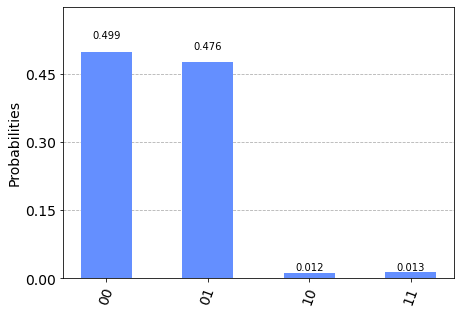

In [4]:
# Running the basic bomb tester circuit

from qiskit.providers.aer import QasmSimulator
simulator = QasmSimulator()

job = simulator.run(circuit, shots=1000)
result = job.result()
counts = result.get_counts(circuit)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

Setup for Noise optimization
## might improve , shorten code

In [5]:
expected_states = ['00', '01', '10', '11']  # target states

def get_state_accuracy(counts): # funciton to calculate state accuracy
    expected_counts = 0
    for state in counts.keys():
        if state in expected_states:
            expected_counts = expected_counts + counts[state]
    state_accuracy = expected_counts / shots
    return str(state_accuracy*100)+"%"

In [6]:
counts = execute(circuit, backend=Aer.get_backend('qasm_simulator'), shots=shots).result().get_counts() # execution on simulator
state_accuracy = get_state_accuracy(counts)
print(f"state accuracy on the simulator: {state_accuracy}")

state accuracy on the simulator: 100.0%


Importing fake Backend

In [7]:
from qiskit.test.mock import *

backends = [FakeVigo()]
backend1 = FakeVigo()

importing backend Santiago

Noise Optimization generally (fake backend)

In [8]:
# compare transpiled circuits for different optimization levels on backend 1

optimization_levels = [0,1,2,3]
print("original circuit")
print(circuit)
for optim_level in optimization_levels:
    print(f"optimization level: {optim_level}")
    transpiled_circuit = transpile(circuit, backend=backend1, optimization_level=optim_level)
    print(transpiled_circuit)
    print(transpiled_circuit.qasm())

original circuit
     ┌──────────┐     ┌──────────┐┌─┐
q_0: ┤ Rx(π/10) ├──■──┤ Rx(-π/2) ├┤M├
     └──────────┘┌─┴─┐└───┬─┬────┘└╥┘
q_1: ────|0>─────┤ X ├────┤M├──────╫─
                 └───┘    └╥┘      ║ 
c: 2/══════════════════════╩═══════╩═
                           1       0 
optimization level: 0
global phase: π
               ┌─────────┐┌────┐┌────────────┐┌────┐┌──────────┐     »
      q_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(11π/10) ├┤ √X ├┤ Rz(5π/2) ├──■──»
               └─────────┘└────┘└────────────┘└────┘└──────────┘┌─┴─┐»
      q_1 -> 1 ────|0>──────────────────────────────────────────┤ X ├»
                                                                └───┘»
ancilla_0 -> 2 ──────────────────────────────────────────────────────»
                                                                     »
ancilla_1 -> 3 ──────────────────────────────────────────────────────»
                                                                     »
ancilla_2 -> 4 ─────────────────────────

Output of the transpiled Circuit

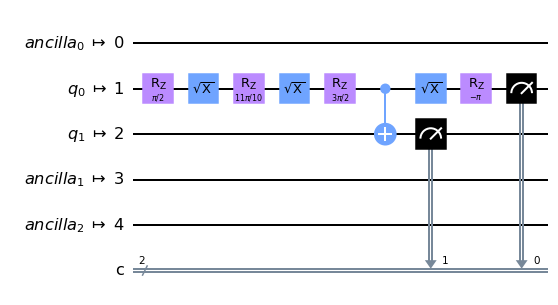

In [9]:
transpiled_circuit.draw(output='mpl')

# Analysis of Probability outcome 
Volaris base qv8 (00)<br>
Volaris noise qv8 (01)<br>
Valaris base qv32 (10)<br>
Volaris noise qv32 (11)<br>

biscuit base qv8 (A)<br>
biscuit noise qv8 (B)<br>
biscuit base qv32 (C)<br>
biscuit noise qv32 (D)<br>

## noise optimization Biscuit V1 
A vs B<br>
C vs D

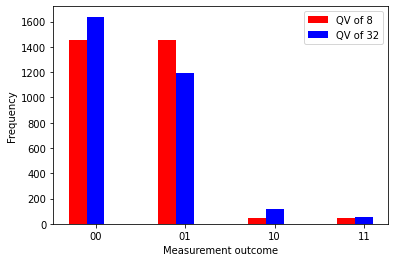

A vs B


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('./Data/A.csv' )
df2 = pd.read_csv('./Data/B.csv')
df1["versuch"]="r"
df2["versuch"]="b"

#print(df)
plt.ylabel("Frequency")
plt.xlabel("Measurement outcome")
plt.bar(x=df1.index-0.1, height=df1["Frequency"],color=df1["versuch"],width=0.2,tick_label=["00","01","10","11"],label='QV of 8')
plt.bar(x=df2.index+0.1, height=df2["Frequency"],color=df2["versuch"],width=0.2,tick_label=["00","01","10","11"],label='QV of 32')
plt.legend()
plt.show()
print("A vs B")

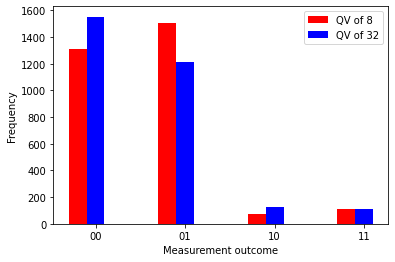

C vs D


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('./Data/CS.csv' )
df2 = pd.read_csv('./Data/DS.csv')
df1["versuch"]="r"
df2["versuch"]="b"

#print(df)
plt.ylabel("Frequency")
plt.xlabel("Measurement outcome")
plt.bar(x=df1.index-0.1, height=df1["Frequency"],color=df1["versuch"],width=0.2,tick_label=["00","01","10","11"],label='QV of 8')
plt.bar(x=df2.index+0.1, height=df2["Frequency"],color=df2["versuch"],width=0.2,tick_label=["00","01","10","11"],label='QV of 32')
plt.legend()
plt.show()
print("C vs D")

## noise optimization Volaris V2 
00 vs 01<br>
10 vs 11

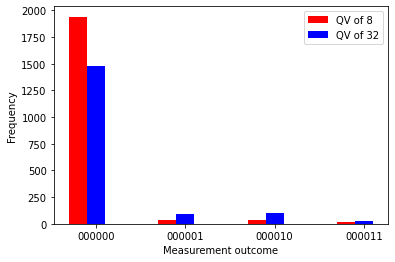

00 vs 01


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('./Data/00.csv' )
df2 = pd.read_csv('./Data/01.csv')
df1["versuch"]="r"
df2["versuch"]="b"

#print(df)
plt.ylabel("Frequency")
plt.xlabel("Measurement outcome")
plt.bar(x=df1.index-0.1, height=df1["Frequency"],color=df1["versuch"],width=0.2,tick_label=["000000","000001","000010","000011"],label='QV of 8')
plt.bar(x=df2.index+0.1, height=df2["Frequency"],color=df2["versuch"],width=0.2,tick_label=["000000","000001","000010","000011"],label='QV of 32')
plt.legend()
plt.show()
print("00 vs 01")
#not functional

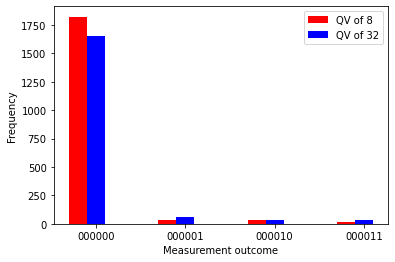

10 vs 11


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('./Data/10.csv' )
df2 = pd.read_csv('./Data/11.csv')
df1["versuch"]="r"
df2["versuch"]="b"

#print(df)
plt.ylabel("Frequency")
plt.xlabel("Measurement outcome")
plt.bar(x=df1.index-0.1, height=df1["Frequency"],color=df1["versuch"],width=0.2,tick_label=["000000","000001","000010","000011"],label='QV of 8')
plt.bar(x=df2.index+0.1, height=df2["Frequency"],color=df2["versuch"],width=0.2,tick_label=["000000","000001","000010","000011"],label='QV of 32')
plt.legend()
plt.show()
print("10 vs 11")
#not functional

## biscuit comparison qv increaes 
A vs C<br>
B vs D

biscuit hardware qv increase comparison

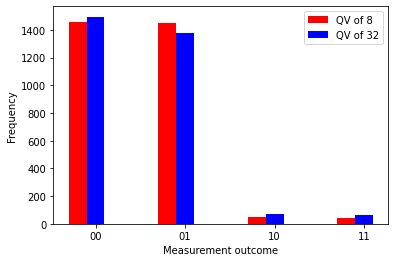

A vs C


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('./Data/A.csv' )
df2 = pd.read_csv('./Data/CM.csv')
df1["versuch"]="r"
df2["versuch"]="b"

#print(df)
plt.ylabel("Frequency")
plt.xlabel("Measurement outcome")
plt.bar(x=df1.index-0.1, height=df1["Frequency"],color=df1["versuch"],width=0.2,tick_label=["00","01","10","11"],label='QV of 8')
plt.bar(x=df2.index+0.1, height=df2["Frequency"],color=df2["versuch"],width=0.2,tick_label=["00","01","10","11"],label='QV of 32')
plt.legend()
plt.show()
print("A vs C")

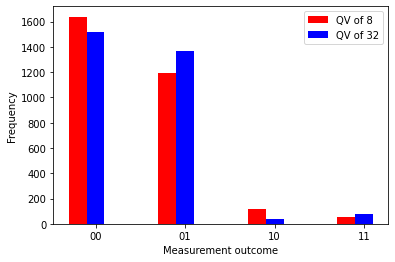

B vs D


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('./Data/B.csv' )
df2 = pd.read_csv('./Data/DM.csv')
df1["versuch"]="r"
df2["versuch"]="b"

#print(df)
plt.ylabel("Frequency")
plt.xlabel("Measurement outcome")
plt.bar(x=df1.index-0.1, height=df1["Frequency"],color=df1["versuch"],width=0.2,tick_label=["00","01","10","11"],label='QV of 8')
plt.bar(x=df2.index+0.1, height=df2["Frequency"],color=df2["versuch"],width=0.2,tick_label=["00","01","10","11"],label='QV of 32')
plt.legend()
plt.show()
print("B vs D")

## Volaris comparison qv increaes 
00 vs 10<br>
01 vs 11

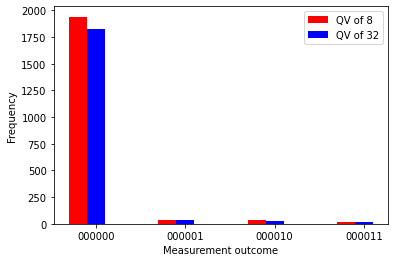

00 vs 10


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('./Data/00.csv' )
df2 = pd.read_csv('./Data/10.csv')
df1["versuch"]="r"
df2["versuch"]="b"

#print(df)
plt.ylabel("Frequency")
plt.xlabel("Measurement outcome")
plt.bar(x=df1.index-0.1, height=df1["Frequency"],color=df1["versuch"],width=0.2,tick_label=["000000","000001","000010","000011"],label='QV of 8')
plt.bar(x=df2.index+0.1, height=df2["Frequency"],color=df2["versuch"],width=0.2,tick_label=["000000","000001","000010","000011"],label='QV of 32')
plt.legend()
plt.show()
print("00 vs 10")
#not functional

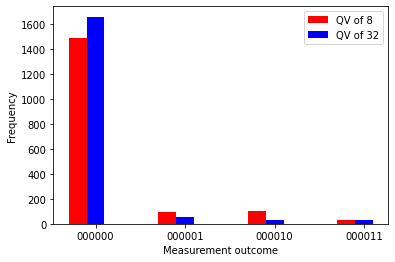

01 vs 11


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('./Data/01.csv' )
df2 = pd.read_csv('./Data/11.csv')
df1["versuch"]="r"
df2["versuch"]="b"

#print(df)
plt.ylabel("Frequency")
plt.xlabel("Measurement outcome")
plt.bar(x=df1.index-0.1, height=df1["Frequency"],color=df1["versuch"],width=0.2,tick_label=["000000","000001","000010","000011"],label='QV of 8')
plt.bar(x=df2.index+0.1, height=df2["Frequency"],color=df2["versuch"],width=0.2,tick_label=["000000","000001","000010","000011"],label='QV of 32')
plt.legend()
plt.show()
print("01 vs 11")
#not functional

## overall increase biscuit
A vs D

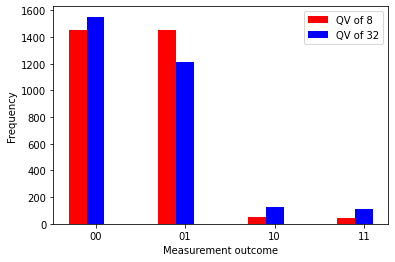

A vs D


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('./Data/A.csv' )
df2 = pd.read_csv('./Data/DS.csv')
df1["versuch"]="r"
df2["versuch"]="b"

#print(df)
plt.ylabel("Frequency")
plt.xlabel("Measurement outcome")
plt.bar(x=df1.index-0.1, height=df1["Frequency"],color=df1["versuch"],width=0.2,tick_label=["00","01","10","11"],label='QV of 8')
plt.bar(x=df2.index+0.1, height=df2["Frequency"],color=df2["versuch"],width=0.2,tick_label=["00","01","10","11"],label='QV of 32')
plt.legend()
plt.show()
print("A vs D")

## overall increase Volaris
00 vs 11

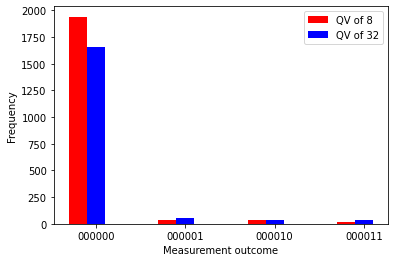

00 vs 11


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('./Data/00.csv' )
df2 = pd.read_csv('./Data/11.csv')
df1["versuch"]="r"
df2["versuch"]="b"

#print(df)
plt.ylabel("Frequency")
plt.xlabel("Measurement outcome")
plt.bar(x=df1.index-0.1, height=df1["Frequency"],color=df1["versuch"],width=0.2,tick_label=["000000","000001","000010","000011"],label='QV of 8')
plt.bar(x=df2.index+0.1, height=df2["Frequency"],color=df2["versuch"],width=0.2,tick_label=["000000","000001","000010","000011"],label='QV of 32')
plt.legend()
plt.show()
print("00 vs 11")
#not functional

Volaris hardware qv increase comparison

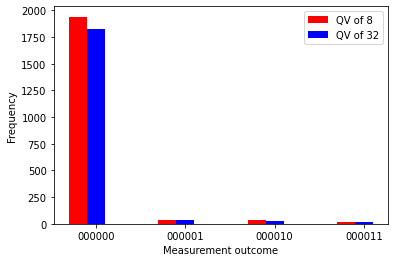

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv('./Data/00.csv' )
df2 = pd.read_csv('./Data/10.csv')
df1["versuch"]="r"
df2["versuch"]="b"

#print(df)
plt.ylabel("Frequency")
plt.xlabel("Measurement outcome")
plt.bar(x=df1.index-0.1, height=df1["Frequency"],color=df1["versuch"],width=0.2,tick_label=["000000","000001","000010","000011"],label='QV of 8')
plt.bar(x=df2.index+0.1, height=df2["Frequency"],color=df2["versuch"],width=0.2,tick_label=["000000","000001","000010","000011"],label='QV of 32')
plt.legend()
plt.show()

Optimizing for backend santiago
## test

In [21]:
IBMQ.save_account('17c5b4b1ba814db12e31fd196aba92d7fc969426cee135ecf7213d619bff7cd27595e05b223b085e5cd872da57c3874e82a12d1b136d3b8868695c7437bf787d',overwrite=True)
priver = IBMQ.load_account()
backend_santi = provider.backend.ibmq_santiago

NameError: name 'provider' is not defined

In [ ]:
optimization_levels = [0,1,2,3]
print("original circuit")
#print(circuit)
for optim_level in optimization_levels:
    print(f"optimization level: {optim_level}")
    transpiled_circuit = transpile(circuit, backend=backend_santi, optimization_level=optim_level)
    print(transpiled_circuit)
    print(transpiled_circuit.qasm())